# Baseline Model

This script applies a linear regression model the data driven feature set, given a baseline preformance for comparison.

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '/config-example.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
epc_train_clean_fname = config['DEFAULT']['epc_train_clean_fname']
epc_test_clean_fname = config['DEFAULT']['epc_test_clean_fname']
epc_train_dd_fname = config['DEFAULT']['epc_train_dd_fname']
epc_test_dd_fname = config['DEFAULT']['epc_test_dd_fname']
epc_fname_suffix = config['DEFAULT']['epc_fname_suffix']

In [3]:
epc_train = pd.read_csv(os.path.join(processing_path,epc_train_dd_fname) + epc_fname_suffix,header = 0,delimiter = ',')
epc_test = pd.read_csv(os.path.join(processing_path,epc_test_dd_fname) + epc_fname_suffix,header = 0,delimiter = ',')

In [4]:
epc_train.drop(['inspection_year'],axis=1,inplace=True)
# epc_test.drop(['TOTAL_FLOOR_AREA'],axis=1,inplace=True)

In [5]:
epc_train.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form,energy_tariff,floor_description,glazed_type,hotwater_description,lighting_description,mainheat_controls,property_type,roof_description,transaction_type,walls_description,window_description,extension,floor_height,habitable_rooms,open_fireplaces
0,69,129.0,End-Terrace,Single,Concrete uninsulated floor pre 1990,Double glazed,Solar,No low energy lighting,I dont know,Few storey building,Insulated horizontally from 1990 to 2002,Stock condition survey,Cavity wall from 2021 to present,Double glazed,0,2.3-2.4,6+,0
1,61,66.0,Semi-Detached,Single,Concrete uninsulated floor pre 1990,Double glazed,Solar,Low energy lighting,I dont know,Few storey building,Insulated horizontally from 1990 to 2002,Stock condition survey,Cavity wall 1980 - 2001,Double glazed,0,NaN,4,0
2,29,290.0,End-Terrace,Single,Concrete uninsulated floor pre 1990,Double glazed,Oil Boiler,Low energy lighting,Programmer: room thermostat,Few storey building,Insulated horizontally from 1990 to 2002,Stock condition survey,Cavity wall 1980 - 2001,Double glazed,1,2.7+,6+,2+
3,55,130.0,End-Terrace,Single,Concrete uninsulated floor pre 1990,Double glazed,Oil Boiler,No low energy lighting,I dont know,Few storey building,Central building Regulations: new build,New dwelling,Cavity wall 2002 - 2020,Double glazed,1,NaN,6+,0
4,77,99.0,Semi-Detached,Dual,I dont know,Single glazed,Solar,Low energy lighting,Programmer: room thermostat,Few storey building,Insulated horizontally from 1990 to 2002,Stock condition survey,Cavity wall from 2021 to present,Double glazed,0,2.3-2.4,5,0


In [6]:
epc_test.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form,energy_tariff,floor_description,glazed_type,hotwater_description,lighting_description,mainheat_controls,property_type,roof_description,transaction_type,walls_description,window_description,extension,floor_height,habitable_rooms,open_fireplaces
0,71,73.00,End-Terrace,Single,Concrete uninsulated floor pre 1990,Double glazed,Solar,Low energy lighting,I dont know,Multiple storey building,Insulated on the slope from 1990 To 2001,I dont know,Cavity wall 2002 - 2020,Double glazed,0,NaN,3,0
1,65,53.00,Semi-Detached,Single,Timber un-insulated floor pre 1990,Single glazed,Solar,Low energy lighting,I dont know,Few storey building,Insulated horizontally from 1990 to 2002,Stock condition survey,Cavity wall 2002 - 2020,Double glazed,0,NaN,3,0
2,81,122.00,Other,Standard Tariff,Insulated Timber 1990 above,NaN,Solar,Low energy lighting,I dont know,Multiple storey building,Insulated horizontally from 2002 to 2021,Social rental,Cavity wall from 2021 to present,Double glazed from 2020,NaN,NaN,NaN,0
3,57,78.87,Semi-Detached,Single,Timber un-insulated floor pre 1990,Double glazed,Solar,I dont know,I dont know,Few storey building,Insulated on the slope from 2021,Private rental,Cavity wall 1960 - 1980,Double glazed,2+,2.3-2.4,5,0
4,64,81.00,Semi-Detached,Single,Concrete uninsulated floor pre 1990,Double glazed,Solar,Low energy lighting,Programmer: room thermostat,Few storey building,Insulated on the slope from 2002 To 2021,New dwelling,Cavity wall 2002 - 2020,Double glazed,0,NaN,5,0


### one hot encode categorical values

In [7]:
epc_train.columns

Index(['CURRENT_ENERGY_EFFICIENCY', 'TOTAL_FLOOR_AREA', 'built_form',
       'energy_tariff', 'floor_description', 'glazed_type',
       'hotwater_description', 'lighting_description', 'mainheat_controls',
       'property_type', 'roof_description', 'transaction_type',
       'walls_description', 'window_description', 'extension', 'floor_height',
       'habitable_rooms', 'open_fireplaces'],
      dtype='object')

In [8]:
# for col in ['MAINS_GAS_FLAG','HEAT_LOSS_CORRIDOR','built_form','energy_tariff','floor_description','floor_level',
#             'glazed_type','hotwater_description','lighting_description','mainheat_controls','property_type',
#             'roof_description','transaction_type','walls_description','window_description','locality','extension',
#             'floor_height','habitable_rooms','open_fireplaces']:
#     print(col)
#     for_dummy = epc_train.pop(col)
#     epc_train = pd.concat([epc_train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [9]:
# for col in ['MAINS_GAS_FLAG','HEAT_LOSS_CORRIDOR','built_form','energy_tariff','floor_description','floor_level',
#             'glazed_type','hotwater_description','lighting_description','mainheat_controls','property_type',
#             'roof_description','transaction_type','walls_description','window_description','locality','extension',
#             'floor_height','habitable_rooms','open_fireplaces']:
#     print(col)
#     for_dummy = epc_test.pop(col)
#     epc_test = pd.concat([epc_test, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [10]:
def process_data_for_modelling(training_data,test_data):
    
    ''' 
    Prepares the data for modelling by one hot encoding the categorical features, converting discrete values into
    strings and dropping BUILDING_REFERENCE_NUMBER
    Parameters
      training_data: a dataframe of training data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
      test_data: a dataframe of test data with columns called LODGEMENT_DATE, BUILDING_REFERENCE_NUMBER
    Returns two dataframes 
    '''
    
    training_data['mode'] = 'train'
    test_data['mode'] = 'test'
    epc = pd.concat([training_data, test_data])
    epc = epc.reset_index(drop = True)
    
    # try:
    #     epc.drop(['LODGEMENT_DATE'],axis=1,inplace=True)
    # except:
    #     pass
    
    try:
        epc['extension'] = epc['extension'].astype('str')
        epc['habitable_rooms'] = epc['habitable_rooms'].astype('str')
    except:
        pass
    
    for col in epc.dtypes[epc.dtypes == 'object'].index:
        if col not in ['mode']:
            print(col)
            for_dummy = epc.pop(col)
            epc = pd.concat([epc, pd.get_dummies(for_dummy, prefix=col)], axis=1)
        
    # features_to_drop = ['BUILDING_REFERENCE_NUMBER']
    # epc.drop(features_to_drop,axis=1,inplace=True)
    
    #Split back into train and test
    training_data = epc[epc['mode']=='train']
    test_data = epc[epc['mode']=='test']
    test_data = test_data.reset_index(drop=True)
    inputs_train = training_data.drop('mode',axis=1)
    inputs_test = test_data.drop('mode',axis=1)
    
    return inputs_train, inputs_test

In [11]:
inputs_train, inputs_test = process_data_for_modelling(epc_train, epc_test)

built_form
energy_tariff
floor_description
glazed_type
hotwater_description
lighting_description
mainheat_controls
property_type
roof_description
transaction_type
walls_description
window_description
extension
floor_height
habitable_rooms
open_fireplaces


In [12]:
inputs_train.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,69,129.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,61,66.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,29,290.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,55,130.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,77,99.0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [13]:
inputs_test.head()

,CURRENT_ENERGY_EFFICIENCY,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,71,73.00,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,65,53.00,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,81,122.00,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,57,78.87,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,64,81.00,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [14]:
# inputs_train, inputs_test = process_data_for_modelling(epc_train, epc_test)

In [15]:
#Extract the target and features
target_train = inputs_train['CURRENT_ENERGY_EFFICIENCY']
inputs_train = inputs_train.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)
target_test = inputs_test['CURRENT_ENERGY_EFFICIENCY']
inputs_test = inputs_test.drop('CURRENT_ENERGY_EFFICIENCY',axis=1)

In [17]:
inputs_train.to_csv('training_data.csv',index = False)
# inputs_test.to_csv('testing_data.csv')

### scale numeric values 

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [81]:
# def scale_numeric(df,col):
    
#     ''' 
#     Fits a scaler called scaler to the specified column
#     Parameters
#       df: a dataframe
#       col: numeric variable to scale
#     Returns a dataframe
#     '''
    
#     null_index = df[col].isnull()
#     df.loc[~null_index, [col]] = scaler.fit_transform(df.loc[~null_index, [col]])
    
#     return df

In [82]:
# inputs_train = scale_numeric(inputs_train,'TOTAL_FLOOR_AREA')
# inputs_test = scale_numeric(inputs_test,'TOTAL_FLOOR_AREA')
# try:
#     inputs_train = scale_numeric(inputs_train,'floor_height')
#     inputs_test = scale_numeric(inputs_test,'floor_height')
# except:
#     pass
# try:
#     inputs_train = scale_numeric(inputs_train,'habitable_rooms')
#     inputs_test = scale_numeric(inputs_test,'habitable_rooms')
# except:
#     pass

### fill missing values

In [83]:
numeric_cols = inputs_train.dtypes[inputs_train.dtypes == 'float'].index

In [84]:
inputs_train[numeric_cols].isnull().sum().sort_values(ascending = False) / inputs_train.shape[0]

TOTAL_FLOOR_AREA    0.0
dtype: float64

In [85]:
inputs_test.head()

,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,energy_tariff_Single,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,73.00,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,53.00,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,122.00,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,78.87,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,81.00,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [86]:
# inputs_train['floor_height'] = inputs_train['floor_height'].fillna(inputs_train['floor_height'].mean())
# inputs_train['habitable_rooms'] = inputs_train['habitable_rooms'].fillna(inputs_train['habitable_rooms'].mean())
# inputs_test['floor_height'] = inputs_test['floor_height'].fillna(inputs_test['floor_height'].mean())
# inputs_test['habitable_rooms'] = inputs_test['habitable_rooms'].fillna(inputs_test['habitable_rooms'].mean())

In [87]:
# inputs_train = inputs_train.drop('HEAT_LOSS_CORRIDOR',axis=1)
# inputs_test = inputs_test.drop('HEAT_LOSS_CORRIDOR',axis=1)

In [88]:
# epc_train[['TOTAL_FLOOR_AREA']].isnull().sum().sort_values(ascending = False) / epc_train.shape[0]

### Create input dataframes

In [89]:
inputs_train.head()

,TOTAL_FLOOR_AREA,built_form_Detached,built_form_End-Terrace,built_form_Mid-Terrace,built_form_Other,built_form_Semi-Detached,energy_tariff_Dual,energy_tariff_I dont know,energy_tariff_Off-Peak,energy_tariff_Single,...,habitable_rooms_1,habitable_rooms_2,habitable_rooms_3,habitable_rooms_4,habitable_rooms_5,habitable_rooms_6+,habitable_rooms_nan,open_fireplaces_0,open_fireplaces_1,open_fireplaces_2+
0,129.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,66.0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,290.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,130.0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,99.0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


### Train the model

In [90]:
i_train = inputs_train.values
t_train = target_train.values.ravel()
i_test = inputs_test.values
t_test = target_test.values.ravel()

In [91]:
i_train

array([[129. ,   0. ,   1. , ...,   1. ,   0. ,   0. ],
       [ 66. ,   0. ,   0. , ...,   1. ,   0. ,   0. ],
       [290. ,   0. ,   1. , ...,   0. ,   0. ,   1. ],
       ...,
       [ 52. ,   0. ,   0. , ...,   1. ,   0. ,   0. ],
       [123.2,   0. ,   1. , ...,   0. ,   1. ,   0. ],
       [ 38. ,   0. ,   0. , ...,   1. ,   0. ,   0. ]])

In [92]:
#Initailise
reg = xgb.XGBRegressor(seed = 1234)
#train
reg.fit(i_train,t_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [93]:
# #Initailise
# reg = xgb.XGBRegressor(n_estimators=250, learning_rate=0.2, max_depth=5)
# #train
# reg.fit(i_train,t_train)

In [94]:
# #View the coefficients
# print('Coefficients: \n', reg.coef_)

# #View the intercept
# print(reg.intercept_)

In [95]:
#Get performance on training data
predict_train = reg.predict(inputs_train)
train_r_squared = r2_score(target_train,predict_train)
train_mse = mean_squared_error(target_train,predict_train)
print('Variance score: %.4f' % train_r_squared)
print("Mean squared error: %.4f" % train_mse)

Variance score: 0.7813
Mean squared error: 46.3134


In [96]:
#Get performance on test data
predict_test = reg.predict(inputs_test)
test_r_squared = r2_score(target_test,predict_test)
test_mse = mean_squared_error(target_test,predict_test)
print('Variance score: %.4f' % test_r_squared)
print("Mean squared error: %.4f" % test_mse)

Variance score: 0.7788
Mean squared error: 46.8727


In [97]:
feature_importance = reg.feature_importances_
feature_importance = pd.DataFrame(feature_importance,columns = ['feature_importance'])
feature_names = inputs_train.columns.values
feature_names = pd.DataFrame(feature_names,columns = ['feature_name'])
feature_importance = pd.merge(feature_names,
                                feature_importance,
                                left_index = True,
                                right_index = True,
                                how = 'inner')
feature_importance.sort_values('feature_importance',
                                ascending = False,
                                inplace = True)

print(feature_importance)

                                         feature_name  feature_importance
79                                      extension_nan            0.490580
63          walls_description_Cavity wall 1980 - 2001            0.058195
62          walls_description_Cavity wall 1960 - 1980            0.054582
29                         hotwater_description_Solar            0.053618
51  roof_description_Insulated on the slope from 2...            0.036447
..                                                ...                 ...
26  hotwater_description_Gas boiler/circulator, wa...            0.000000
71  walls_description_trawsyriannedd thermol cyfar...            0.000000
44        roof_description_Always, limited insulation            0.000000
27  hotwater_description_No system present: electr...            0.000000
22  hotwater_description_Electric immersion, off-p...            0.000000

[96 rows x 2 columns]


### Tune the model

In [ ]:
learning_rate_set = [0.1,0.2,0.3,0.4] #Learning rate
n_estimators_set = [150,200,250]  #Number of trees
max_depth_set = [3,4,5] #Depth of tree

In [ ]:
# sample of datasets to speed up training
inputs_train_sample = inputs_train.iloc[:50000,:]
target_train_sample = target_train.iloc[:50000]

In [ ]:
def tune_model(inputs_train, target_train, inputs_test, target_test, model=['adaboost','GBT','forest','xgboost'],
              learning_rate_set, n_estimators_set, max_depth_set):
    
    ''' 
    Fits one of four models, Adaboost, Gradient Boosted Trees, Random Forest or XGBoost, tunes using the 
    specified parameter sets. Note this takes a long time to run and the compuation time will increase with
    the number of parameters
    Parameters
      inputs_train: a dataframe of training data
      target_train: a series of the target for training
      input__test: a dataframe of test data must have the same columns as inputs_train
      target_test: a series of the target for testing
      model: ['adaboost','GBT','forest','xgboost']
      learning_rate_set: set of learning rates to test
      n_estimators_set: set of number of trees to test
      max_depth_set: set of max tree depths to test
    '''
    
    if model == 'adaboost':
        reg = AdaBoostRegressor(random_state = 1234)
    elif model == 'GBT':
        reg = GradientBoostingRegressor(random_state = 1234)
    elif model == 'forest':
        reg = RandomForestRegressor(n_jobs = -1, random_state = 1234)
    else:
        i_train = inputs_train.values
        t_train = target_train.values.ravel()
        i_test = inputs_test.values
        t_test = target_test.values.ravel()
        reg = xgb.XGBRegressor(seed = 1234)
        
    parameters = {'learning_rate':learning_rate_set, 'n_estimators':n_estimators_set, 'max_depth':max_depth_set}
    reg_tuned = GridSearchCV(reg, parameters)
    reg_tuned.fit(inputs_train, target_train)
        
    if model in ['adaboost','GBT','forest']:
        reg_tuned.fit(inputs_train, target_train)    
    else:
        reg_tuned.fit(i_train, t_train)
    
    print(reg_tuned.best_params_)
    print(reg_tuned.best_score_)

In [ ]:
train_model(inputs_train_sample, target_train_sample, inputs_test, target_test, 'xgboost')

## Results by band

predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [98]:
predict_test_series = pd.Series(predict_test)
test_scored = pd.DataFrame(target_test)
test_scored = test_scored.reset_index(drop=True)
test_scored['predicted_score'] = predict_test_series

In [99]:
band_bins = [-1,0,20,38,54,68,80,91,100]
band_labels = ['I','G','F','E','D','C','B','A']
test_scored['predicted_band'] = pd.cut(test_scored['predicted_score'],bins = band_bins, labels = band_labels)
test_scored['actual_band'] = pd.cut(test_scored['CURRENT_ENERGY_EFFICIENCY'],bins = band_bins, labels = band_labels)

In [100]:
# average accuracy per band
(test_scored['actual_band'] == test_scored['predicted_band']).sum()/len(test_scored)

0.6828031117183856

In [101]:
# accuracy for each band
test_scored['correct_band'] = test_scored['actual_band'] == test_scored['predicted_band']
test_scored.groupby('actual_band')['correct_band'].sum()/test_scored.groupby('actual_band')['correct_band'].count()

actual_band
I    0.000000
G    0.280382
F    0.374150
E    0.551539
D    0.743868
C    0.693873
B    0.802493
A    0.000000
Name: correct_band, dtype: float64

In [102]:
# manipulating data for heatmap
for_heatmap = test_scored[['actual_band','predicted_band']]
for_dummy = for_heatmap.pop('actual_band')
for_heatmap = pd.concat([for_heatmap, pd.get_dummies(for_dummy)], axis=1)
for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_10160\3882052621.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  for_heatmap_summed = for_heatmap.groupby('predicted_band')['A','B','C','D','E','F','G'].sum()


In [103]:
def get_pct(x):
    return (x/(x.sum()))*100

In [104]:
for_heatmap_summed = for_heatmap_summed.apply(get_pct,axis = 0)

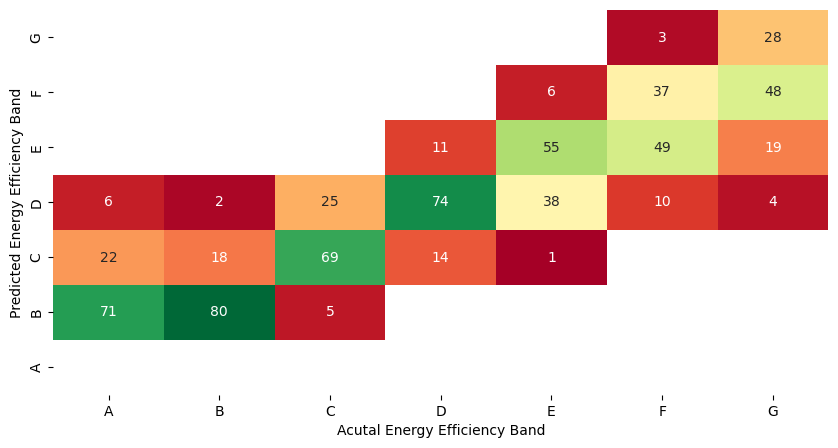

In [105]:
heatmap_test = round(for_heatmap_summed,0)
heatmap_test = heatmap_test.replace(0,np.nan)
heatmap_test = heatmap_test.loc[['G','F','E','D','C','B','A'],:]

f = plt.figure(figsize=(10,5))
sns.heatmap(heatmap_test, cmap='RdYlGn',annot=True,cbar=False)
plt.xlabel('Acutal Energy Efficiency Band')
plt.ylabel('Predicted Energy Efficiency Band')
plt.show()

In [106]:
reg.save_model("EnergyEfficiencyTool2.json")

In [107]:
inputs_train.to_csv('training_data.csv', index = False)
# inputs_test.to_csv('testing_data.csv')

In [108]:
inputs_train.columns.values.tolist()

['TOTAL_FLOOR_AREA',
 'built_form_Detached',
 'built_form_End-Terrace',
 'built_form_Mid-Terrace',
 'built_form_Other',
 'built_form_Semi-Detached',
 'energy_tariff_Dual',
 'energy_tariff_I dont know',
 'energy_tariff_Off-Peak',
 'energy_tariff_Single',
 'energy_tariff_Standard Tariff',
 'floor_description_Concrete uninsulated floor pre 1990',
 'floor_description_I dont know',
 'floor_description_Insulated Timber 1990 above',
 'floor_description_Insulated concrete 1990 above',
 'floor_description_Timber un-insulated floor pre 1990',
 'glazed_type_Double glazed',
 'glazed_type_Double glazed from 2020',
 'glazed_type_I dont know',
 'glazed_type_Single glazed',
 'hotwater_description_Coal Boiler',
 'hotwater_description_Electric Heating',
 'hotwater_description_Electric immersion, off-peak, plus solar, waste water heat recovery',
 'hotwater_description_From main heating system, no cylinderstat',
 'hotwater_description_Fuel Boiler',
 'hotwater_description_Gas Boiler',
 'hotwater_descriptio